In [3]:
# %%
import sys
sys.path.append('/public/src')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import joblib
import os
import warnings
warnings.filterwarnings('ignore')

from factor_evaluation_server import FactorEvaluation, DataService

# 初始化数据服务
ds = DataService()
df = ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

# 读取已有因子数据
factor_path = "/public/data/factor_data/ETHUSDT_15m_2020_2025_factor_data.pkl"
factors = pd.read_pickle(factor_path)

# 检查是否有时间索引，如果有则重置为整数索引
if isinstance(factors.index, pd.DatetimeIndex) or factors.index.dtype == 'datetime64[ns]':
    factors = factors.reset_index(drop=True)

# 保存原始列名（旧因子）
original_columns = factors.columns.tolist()
print(f"加载了 {len(original_columns)} 个旧因子")

加载了 141 个旧因子


In [4]:
# 定义所有新因子计算函数
def calculate_filter_001_1(df):
    '''衡量当前波动率高低的过滤器'''
    log_ratio = np.log(df['close'] / df['close'].shift(1))
    hv = log_ratio.rolling(20).std()
    return hv

def calculate_filter_001_2(df):
    '''ATR过滤器'''
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(14).mean()
    return atr

def calculate_filter_001_3_keltner_channels(df, ema_period=20, atr_period=10, multiplier=2):
    '''凯尔特纳通道：基于ATR的波动通道'''
    ema = df['close'].ewm(span=ema_period, adjust=False).mean()
    
    # 计算ATR
    high_low = df['high'] - df['low']
    high_close = abs(df['high'] - df['close'].shift(1))
    low_close = abs(df['low'] - df['close'].shift(1))
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.ewm(span=atr_period, adjust=False).mean()
    
    # 计算通道宽度
    channel_width = multiplier * atr
    return (df['close'] - (ema - channel_width)) / (2 * channel_width)

def calculate_filter_002_1(df):
    '''衡量当前成交量高低的过滤器'''
    volume_mean = df['volume'].rolling(20).mean()
    volume_deviation = (df['volume'] - volume_mean) / volume_mean
    return volume_deviation

def calculate_filter_002_2_obv(df):
    '''能量潮指标：累积成交量平衡'''
    obv = (np.sign(df['close'].diff()) * df['volume'])
    obv = obv.cumsum()
    return obv

def calculate_filter_002_3_vwap(df):
    '''成交量加权平均价'''
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    vwap = (typical_price * df['volume']).cumsum() / df['volume'].cumsum()
    return vwap

def calculate_filter_003(df):
    '''衡量当前相对位置高低的过滤器'''
    up = df['high'].rolling(20).max()
    down = df['low'].rolling(20).min()
    price_position = (df['close'] - down) / (up - down)
    return price_position

def calculate_filter_004(df):
    '''衡量短期价格波动快慢的过滤器'''
    std_5 = df['close'].rolling(5).std()
    std_30 = df['close'].rolling(30).std()
    price_fluctuation = std_5 / std_30
    return price_fluctuation

def calculate_filter_005(df):
    '''
    衡量买卖压力的比例的过滤器
    '''
    imbalance = 2 * df['taker_buy_volume'] / df['volume'] - 1
    return imbalance

def calculate_filter_006(df):
    '''
    衡量平均交易量的过滤器
    '''
    average_trade_size = df['volume'] / df['trade_count']
    return average_trade_size

def calculate_filter_007(df):
    '''
    衡量 candle body 相对价格范围的大小的过滤器
    '''
    body = abs(df['close'] - df['open'])
    range_ = df['high'] - df['low']
    body_to_range_ratio = body / range_
    return body_to_range_ratio

def calculate_filter_008(df):
    '''衡量上影线相对价格范围的大小的过滤器'''
    upper_wick = df['high'] - df[['open', 'close']].max(axis=1)
    range_ = df['high'] - df['low']
    upper_wick_ratio = upper_wick / range_
    return upper_wick_ratio

def calculate_filter_009(df):
    '''衡量下影线相对价格范围的大小的过滤器'''
    lower_wick = df[['open', 'close']].min(axis=1) - df['low']
    range_ = df['high'] - df['low']
    lower_wick_ratio = lower_wick / range_
    return lower_wick_ratio

def calculate_filter_010_1(df, period=14):
    '''
    衡量RSI的过滤器
    '''
    delta = df['close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()
    rs = avg_gain / avg_loss.replace([np.inf, -np.inf], np.nan).fillna(0)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_filter_010_2_mfi(df, period=14):
    '''资金流量指数：结合价格和成交量的RSI变体'''
    typical_price = (df['high'] + df['low'] + df['close']) / 3
    raw_money_flow = typical_price * df['volume']
    money_flow_direction = np.where(typical_price > typical_price.shift(1), 1, -1)
    positive_flow = raw_money_flow.where(money_flow_direction > 0, 0)
    negative_flow = raw_money_flow.where(money_flow_direction < 0, 0)
    money_ratio = positive_flow.rolling(period).sum() / negative_flow.rolling(period).sum()
    money_ratio = money_ratio.replace([np.inf, -np.inf], np.nan).fillna(1)
    mfi = 100 - (100 / (1 + money_ratio))
    return mfi

def calculate_filter_011(df, short_period=12, long_period=26):
    '''
    衡量MACD的过滤器
    '''
    short_ema = df['close'].ewm(span=short_period, adjust=False).mean()
    long_ema = df['close'].ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    return macd

def calculate_filter_012_aroon_up(df, period=14):
    '''阿隆上升指标：衡量价格创新高的能力'''
    high_idx = df['high'].rolling(period).apply(lambda x: x.argmax(), raw=True)
    aroon_up = 100 * (period - high_idx) / period
    return aroon_up

def calculate_filter_013_aroon_down(df, period=14):
    '''阿隆下降指标：衡量价格创新低的能力'''
    low_idx = df['low'].rolling(period).apply(lambda x: x.argmin(), raw=True)
    aroon_down = 100 * (period - low_idx) / period
    return aroon_down

def calculate_filter_014_aroon_oscillator(df, period=14):
    '''阿隆震荡器：衡量趋势强度'''
    aroon_up = calculate_filter_012_aroon_up(df, period)
    aroon_down = calculate_filter_013_aroon_down(df, period)
    return aroon_up - aroon_down

def calculate_filter_015_chaikin_money_flow(df, period=20):
    '''
    Chaikin资金流(CMF)
    '''
    money_flow_multiplier = ((df['close'] - df['low']) - (df['high'] - df['close'])) / (df['high'] - df['low'])
    money_flow_multiplier = money_flow_multiplier.replace([np.inf, -np.inf], 0).fillna(0)
    money_flow_volume = money_flow_multiplier * df['volume']
    cmf = money_flow_volume.rolling(period).sum() / df['volume'].rolling(period).sum()
    return cmf

def calculate_filter_020_volume_price_trend(df):
    '''量价趋势指标：结合价格变动和成交量'''
    price_change = df['close'].pct_change()
    vpt = (price_change * df['volume']).cumsum()
    return vpt

In [5]:
# 所有新因子计算函数的映射
factor_calculators = {
    'filter_001_1': calculate_filter_001_1,
    'filter_001_2': calculate_filter_001_2,
    'filter_001_3': lambda df: calculate_filter_001_3_keltner_channels(df),
    'filter_002_1': calculate_filter_002_1,
    'filter_002_2': calculate_filter_002_2_obv,
    'filter_002_3': calculate_filter_002_3_vwap,
    'filter_003': calculate_filter_003,
    'filter_004': calculate_filter_004,
    'filter_005': calculate_filter_005,
    'filter_006': calculate_filter_006,
    'filter_007': calculate_filter_007,
    'filter_008': calculate_filter_008,
    'filter_009': calculate_filter_009,
    'filter_010_1': lambda df: calculate_filter_010_1(df, 14),
    'filter_010_2': lambda df: calculate_filter_010_2_mfi(df, 14),
    'filter_011': lambda df: calculate_filter_011(df, 12, 26),
    'filter_012': lambda df: calculate_filter_012_aroon_up(df, 14),
    'filter_013': lambda df: calculate_filter_013_aroon_down(df, 14),
    'filter_014': lambda df: calculate_filter_014_aroon_oscillator(df, 14),
    'filter_015': lambda df: calculate_filter_015_chaikin_money_flow(df, 20),
    'filter_020': calculate_filter_020_volume_price_trend
}

In [ ]:
# 计算并添加所有新因子
print("\n开始计算新因子...")
for factor_name, calculator in tqdm(factor_calculators.items(), desc="计算因子"):
    try:
        # 计算因子值并转换为pandas Series
        factor_values = calculator(df)
        if isinstance(factor_values, pd.Series):
            # 确保长度与factors一致
            if len(factor_values) != len(factors):
                # 截断或填充以匹配长度
                factor_values = factor_values.iloc[:len(factors)].reset_index(drop=True)
            factors[factor_name] = factor_values.values
        else:
            # 处理numpy数组
            if len(factor_values) != len(factors):
                factor_values = factor_values[:len(factors)]
            factors[factor_name] = factor_values
    except Exception as e:
        print(f"计算因子 {factor_name} 时出错: {str(e)}")
        # 添加空列以保持数据结构
        factors[factor_name] = np.nan

# 确保索引对齐
factors = factors.reset_index(drop=True)


开始计算新因子...


计算因子: 100%|██████████| 21/21 [00:00<00:00, 30.17it/s]



计算相关系数矩阵...


In [ ]:
# 计算相关系数矩阵
print("\n计算相关系数矩阵...")
corr_matrix = factors.corr()

# 提取新因子与旧因子的相关系数
new_factors = list(factor_calculators.keys())
old_factors = original_columns
new_to_old_corr = corr_matrix.loc[new_factors, old_factors]

In [7]:
# 设置相关性阈值
threshold = 0.7
high_corr_records = []  # 用于存储高相关性记录

print(f"\n高相关性因子分析 (新因子与旧因子, |corr| > {threshold}):")
for new_factor in new_factors:
    # 只考虑与旧因子的相关性
    corr_series = new_to_old_corr.loc[new_factor]
    
    # 找出相关性绝对值超过阈值的因子
    high_corr = corr_series[abs(corr_series) > threshold]
    
    if not high_corr.empty:
        print(f"\n🔍 {new_factor} 与以下旧因子有高相关性:")
        for factor, corr_value in high_corr.items():
            # 判断相关性强弱和方向
            strength = "强" if abs(corr_value) > 0.8 else "中等"
            direction = "正" if corr_value > 0 else "负"
            
            print(f"  - {factor}: {corr_value:.4f} ({strength}{direction}相关)")
            high_corr_records.append({
                '新因子': new_factor,
                '旧因子': factor,
                '相关系数': corr_value,
                '相关强度': strength,
                '相关方向': direction
            })


高相关性因子分析 (新因子与旧因子, |corr| > 0.7):

🔍 filter_001_1 与以下旧因子有高相关性:
  - c_chu001: 1.0000 (强正相关)
  - c_chu005: 0.7070 (中等正相关)
  - c_chu028: 0.7239 (中等正相关)

🔍 filter_001_2 与以下旧因子有高相关性:
  - c_chu001: 0.7252 (中等正相关)
  - c_chu005: 0.9762 (强正相关)
  - c_chu024: 0.9164 (强正相关)
  - c_chu025: 0.7661 (中等正相关)

🔍 filter_001_3 与以下旧因子有高相关性:
  - ret_kc_strategy: -0.7005 (中等负相关)
  - ret_macd_02_cross_sig_price: 0.7562 (中等正相关)
  - ret_dc_bbi_cross_sig_price: 0.8329 (强正相关)
  - c_chu003: 0.8743 (强正相关)
  - c_chu006: 0.9740 (强正相关)
  - c_chu010: 0.8747 (强正相关)
  - c_chu015: -0.8132 (强负相关)
  - c_chu016: 0.8026 (强正相关)
  - c_chu053: 0.9400 (强正相关)
  - c_chu057: 0.7706 (中等正相关)
  - c_chu061: 0.7971 (中等正相关)

🔍 filter_002_1 与以下旧因子有高相关性:
  - c_chu002: 1.0000 (强正相关)

🔍 filter_002_2 与以下旧因子有高相关性:
  - open_time: -0.8438 (强负相关)
  - close_time: -0.8438 (强负相关)
  - c_chu007: -0.8743 (强负相关)

🔍 filter_003 与以下旧因子有高相关性:
  - ret_williams_r_sig_price: -0.7435 (中等负相关)
  - ret_macd_02_cross_sig_price: 0.7281 (中等正相关)
  - ret_dc_bbi_cross_si

In [8]:
# 在Notebook中直接显示高相关性因子表格
if high_corr_records:
    high_corr_df = pd.DataFrame(high_corr_records)
    
    # 美化显示表格
    print("\n📊 高相关性因子汇总表 (新因子 vs 旧因子):")
    display(high_corr_df[['新因子', '旧因子', '相关系数', '相关强度', '相关方向']]
            .sort_values(by='相关系数', key=abs, ascending=False)
            .style
            .background_gradient(cmap='coolwarm', subset=['相关系数'])
            .format({'相关系数': "{:.4f}"})
            .set_caption(f"高相关性因子汇总 (|corr| > {threshold})"))
else:
    print(f"\n✅ 未发现高相关性新因子与旧因子 (|corr| > {threshold})")


📊 高相关性因子汇总表 (新因子 vs 旧因子):


,新因子,旧因子,相关系数,相关强度,相关方向
33,filter_004,c_chu004,1.0000,强,正
0,filter_001_1,c_chu001,1.0000,强,正
25,filter_003,c_chu003,1.0000,强,正
18,filter_002_1,c_chu002,1.0000,强,正
43,filter_010_1,c_chu006,0.9999,强,正
4,filter_001_2,c_chu005,0.9762,强,正
11,filter_001_3,c_chu006,0.9740,强,正
47,filter_010_1,c_chu053,0.9654,强,正
15,filter_001_3,c_chu053,0.9400,强,正
5,filter_001_2,c_chu024,0.9164,强,正


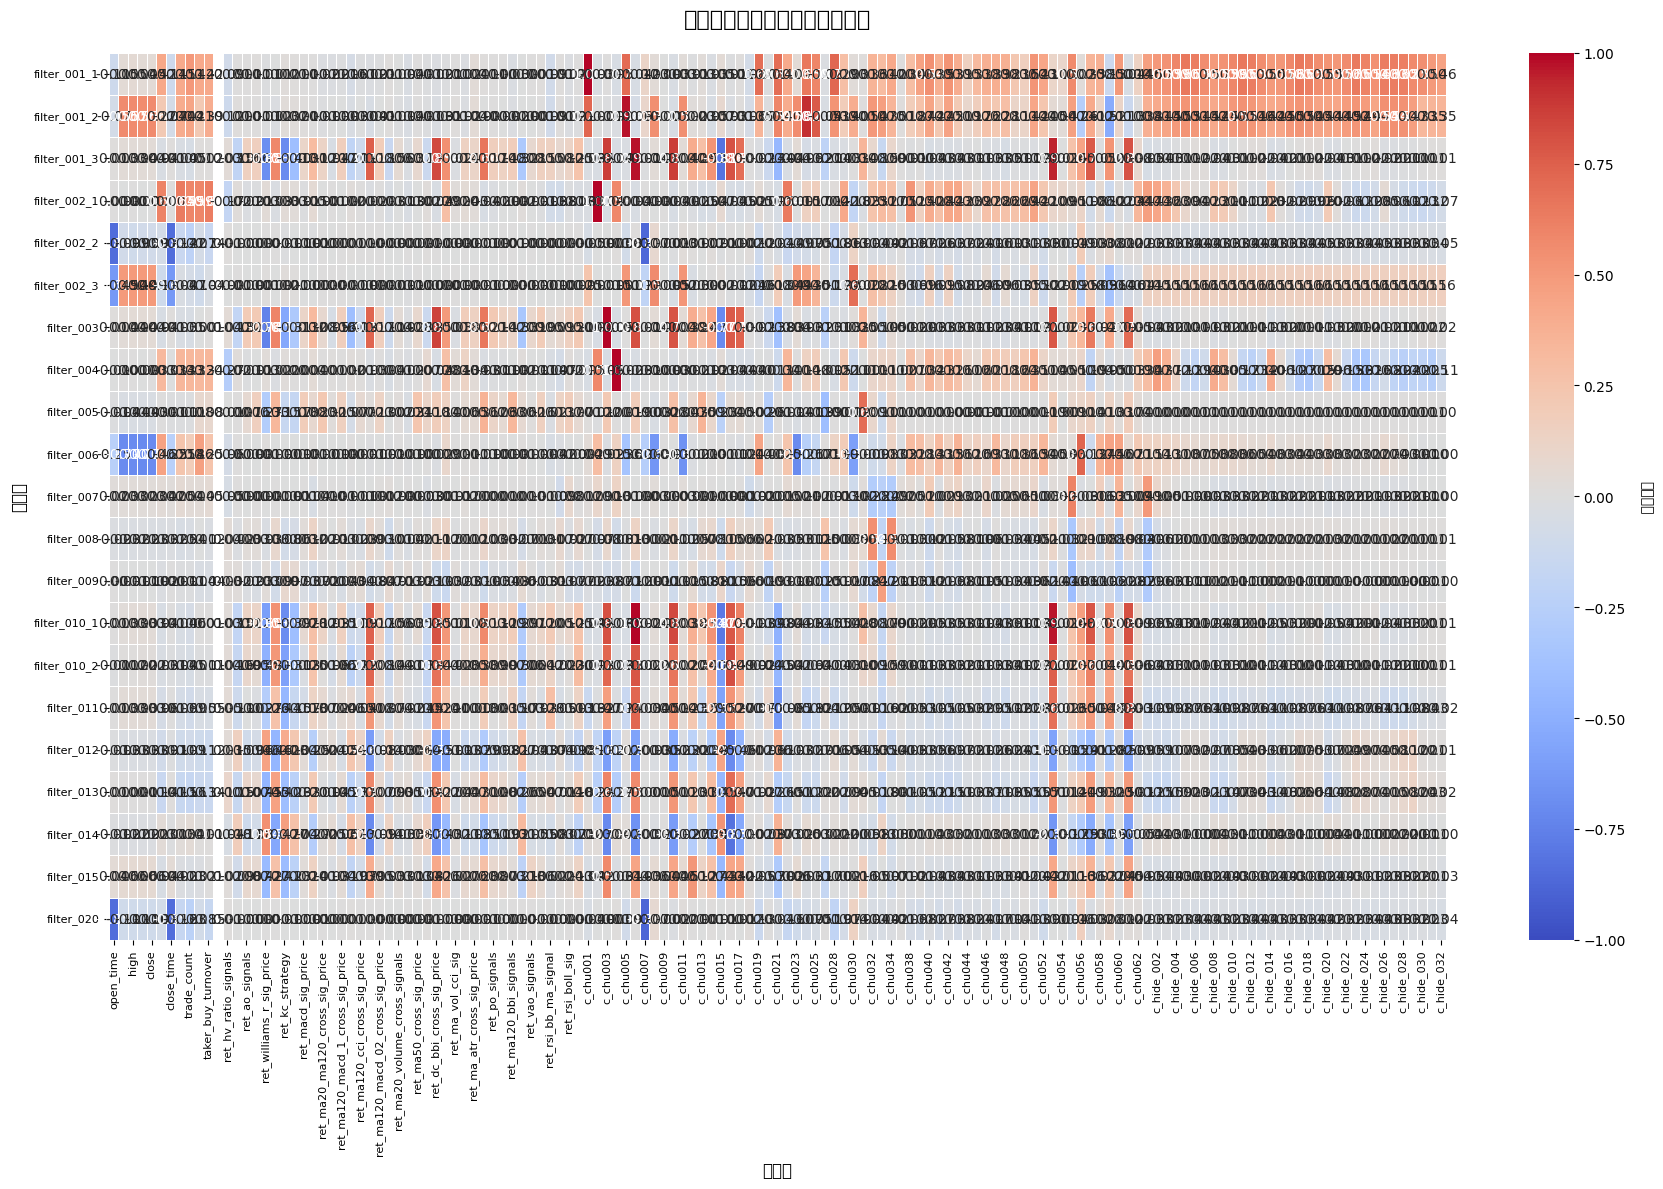

In [9]:
# 可视化：新因子与旧因子的相关性热力图
plt.figure(figsize=(18, 12))
sns.heatmap(
    new_to_old_corr,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    linewidths=0.5
)
plt.title('新因子与旧因子的相关性热力图', fontsize=16, pad=20)
plt.xlabel('旧因子', fontsize=12)
plt.ylabel('新因子', fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)

# 添加颜色条说明
cbar = plt.gcf().axes[-1]
cbar.set_ylabel('相关系数', rotation=270, labelpad=20)

# 直接在Notebook中显示图表
plt.tight_layout()
plt.show()

In [10]:
# 加载同质异质分离数据（如果存在）
homo_hetero_path = "/public/data/factor_data/ETHUSDT_15m_2020_2025_homo_heter_split.joblib"
if os.path.exists(homo_hetero_path):
    try:
        homo_hetero_data = joblib.load(homo_hetero_path)
        print("\n加载同质异质分离数据成功!")
        # 这里可以添加对同质异质数据的分析代码
    except Exception as e:
        print(f"\n加载同质异质分离数据时出错: {str(e)}")
else:
    print("\n未找到同质异质分离数据文件")

print("\n🎉 因子相关性分析完成!")


加载同质异质分离数据成功!

🎉 因子相关性分析完成!
